# Feature Reduction

This notebook demonstrates how to use various feature selection methods using scalecast. The idea behind this example is to reduce the variables stored in the `Forecaster` object to an optimal subset after adding many potentially helpful features to the object.  

- Link to [data](https://www.kaggle.com/robervalt/sunspots)    
- See the [blog post](https://medium.com/towards-data-science/variable-reduction-techniques-for-time-series-646743f726d4)  
- [Function documentation link](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.reduce_Xvars)  

![](mermaid-diagram-2023-02-05-132837.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scalecast.Forecaster import Forecaster
from scalecast.util import plot_reduction_errors

In [2]:
sns.set(rc={"figure.figsize": (12, 8)})

In [3]:
def prepare_fcst(f, test_length=120, fcst_length=120, validation_length=120):
    """ adds all variables and sets the test length/forecast length in the object
    
    Args:
        f (Forecaster): the Forecaster object.
        test_length (int or float): the test length as a size or proportion.
        fcst_length (int): the forecast horizon.
        
    Returns:
        (Forecaster) the processed object.
    """
    f.generate_future_dates(fcst_length)
    f.set_test_length(test_length)
    f.set_validation_length(validation_length)
    f.add_seasonal_regressors("month", "quarter", raw=False, sincos=True)
    f.set_validation_metric("mae")
    for i in np.arange(12, 289, 12):  # 12-month cycles from 12 to 288 months
        f.add_cycle(i)
    f.add_ar_terms(120)  # AR 1-120
    f.add_AR_terms((20, 12))  # seasonal AR up to 20 years, spaced one year apart
    f.add_time_trend()
    f.add_seasonal_regressors("year")
    return f


def export_results(f):
    """ returns a dataframe with all model results given a Forecaster object.
    
    Args:
        f (Forecaster): the Forecaster object.
        
    Returns:
        (DataFrame) the dataframe with the pertinent results.
    """
    results = f.export("model_summaries", determine_best_by="TestSetMAE")
    results["N_Xvars"] = results["Xvars"].apply(lambda x: len(x))
    return results[
        [
            "ModelNickname",
            "TestSetMAE",
            "InSampleMAE",
            "TestSetR2",
            "InSampleR2",
            "DynamicallyTested",
            "N_Xvars",
        ]
    ]

## Load Forecaster Object
- we choose 120 periods (10 years) for all validation and forecasting
- 10 years of observervations to tune model hyperparameters, 10 years to test, and a forecast horizon of 10 years

In [4]:
df = pd.read_csv("Sunspots.csv", index_col=0, names=["Date", "Target"], header=0)
f = Forecaster(y=df["Target"], current_dates=df["Date"])
prepare_fcst(f)

Forecaster(
    DateStartActuals=1749-01-31T00:00:00.000000000
    DateEndActuals=2021-01-31T00:00:00.000000000
    Freq=M
    N_actuals=3265
    ForecastLength=120
    Xvars=['monthsin', 'monthcos', 'quartersin', 'quartercos', 'cycle12sin', 'cycle12cos', 'cycle24sin', 'cycle24cos', 'cycle36sin', 'cycle36cos', 'cycle48sin', 'cycle48cos', 'cycle60sin', 'cycle60cos', 'cycle72sin', 'cycle72cos', 'cycle84sin', 'cycle84cos', 'cycle96sin', 'cycle96cos', 'cycle108sin', 'cycle108cos', 'cycle120sin', 'cycle120cos', 'cycle132sin', 'cycle132cos', 'cycle144sin', 'cycle144cos', 'cycle156sin', 'cycle156cos', 'cycle168sin', 'cycle168cos', 'cycle180sin', 'cycle180cos', 'cycle192sin', 'cycle192cos', 'cycle204sin', 'cycle204cos', 'cycle216sin', 'cycle216cos', 'cycle228sin', 'cycle228cos', 'cycle240sin', 'cycle240cos', 'cycle252sin', 'cycle252cos', 'cycle264sin', 'cycle264cos', 'cycle276sin', 'cycle276cos', 'cycle288sin', 'cycle288cos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10

In [5]:
print("starting out with {} variables".format(len(f.get_regressor_names())))

starting out with 184 variables


## Reducing with L1 Regularization
- L1 regularization reduces out least important variables using a lasso model
- Not computationally expensive
- `overwrite=False` is used to not replace variables currently in the `Forecaster` object

In [6]:
f.reduce_Xvars(overwrite=False, dynamic_testing=False)

In [7]:
lasso_reduced_vars = f.reduced_Xvars[:]
print(f"lasso reduced to {len(lasso_reduced_vars)} variables")

lasso reduced to 59 variables


In [8]:
print(*lasso_reduced_vars, sep="\n")

monthcos
quartersin
cycle12cos
cycle24sin
cycle24cos
cycle36cos
cycle48cos
cycle60sin
cycle60cos
cycle72sin
cycle84sin
cycle84cos
cycle96sin
cycle96cos
cycle108sin
cycle108cos
cycle120sin
cycle120cos
cycle132sin
cycle132cos
cycle144sin
cycle156sin
cycle168cos
cycle180sin
cycle192cos
cycle204sin
cycle216sin
cycle216cos
cycle228sin
cycle252sin
cycle252cos
cycle264cos
cycle288sin
cycle288cos
AR1
AR2
AR3
AR4
AR5
AR6
AR8
AR9
AR10
AR11
AR18
AR21
AR27
AR28
AR29
AR34
AR35
AR92
AR102
AR108
AR111
AR113
AR116
AR117
AR216


## Reducing with Permutation Feature Importance
- uses the [ELI5 package](https://github.com/eli5-org/eli5) to score feature importances
- eliminates the least-scoring variable (with some scalecast adjustment to account for collinearity), re-trains the model, and evaluates the new error
- by default, the Xvars that return the best error score (according to any metric you want to monitor) is chosen as the optimal set of variables
- to save computation resources, not every variable combination is tried (unlike other reduction techniques)
- to save computation resources, we can set `dynamic_testing = False` and we can set a mininum number of variables to use (the square root of the total number of observations is chosen in this example)
- we can use any sklearn model to reduce variables using this method and we select MLR, KNN, GBT, and SVR in this example

In [9]:
f.reduce_Xvars(
    method="pfi",
    estimator="mlr",
    keep_at_least="sqrt",
    grid_search=False,
    normalizer="minmax",
    overwrite=False,
)

2023-04-11 12:03:53.245099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
mlr_reduced_vars = f.reduced_Xvars[:]
print(f"mlr with pfi reduced to {len(mlr_reduced_vars)} variables")

mlr with pfi reduced to 166 variables


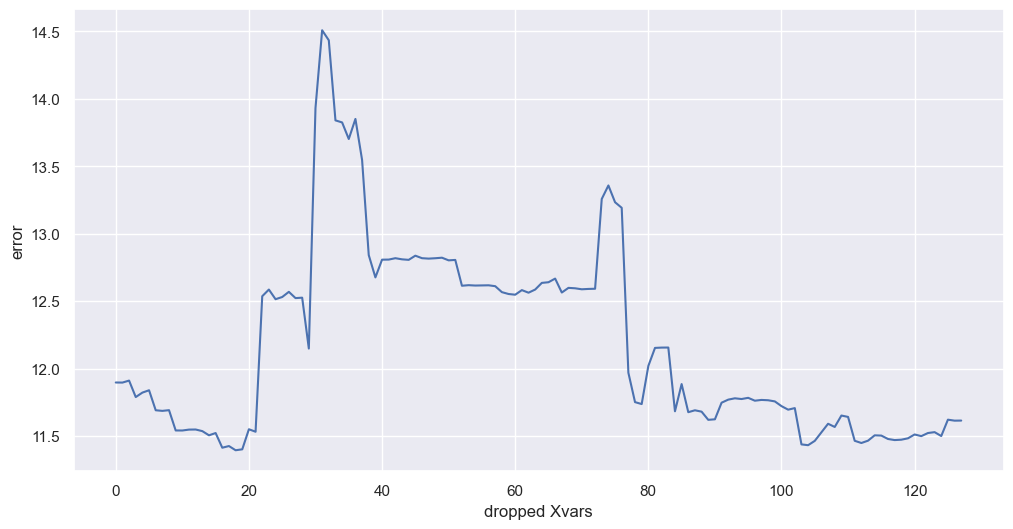

In [11]:
plot_reduction_errors(f)
plt.show()

The above graph shows that the MLR performs best when about 50 variables are reduced, according to the MAE on the validation set. The order the variables were dropped was based on permutation feature importance. Clearly, too many variables had been added initially and reducing them out made a significant positive difference to the model's performance. Note, the error metric monitored is not from the test set, but from a different out-of-sample slice of data. Later models use the test set to validate the decisions that were made while monitoring this validation metric.

In [12]:
def reduce_and_save_results(f, model, results):
    f.reduce_Xvars(
        method="pfi",
        estimator=model,
        keep_at_least="sqrt",
        grid_search=True,
        dynamic_testing=False,
        overwrite=False,
    )
    results[model] = [
        f.reduced_Xvars,
        f.pfi_dropped_vars,
        f.pfi_error_values,
        f.reduction_hyperparams,
    ]

In [ ]:
results = {
    "mlr": [
        f.reduced_Xvars,
        f.pfi_dropped_vars,
        f.pfi_error_values,
        f.reduction_hyperparams,
    ]
}

for model in ("knn", "gbt", "svr"):
    print(f"reducing with {model}")
    reduce_and_save_results(f, model, results)

reducing with knn


In [ ]:
for k, v in results.items():
    print(f"the {k} model chose {len(v[0])} variables")
    sns.lineplot(x=np.arange(0, len(v[1]) + 1, 1), y=v[2], label=k)
plt.xlabel("dropped Xvars")
plt.ylabel("error")
plt.show()

Out of the four models we tried using pfi, the gbt model scored the best on the validation set with 136 variables. We will re-train that model with each of the reduced set of variables and see which reduction performs best on the test set. We will use the best-performing model class from the four we tried: gbt. There is no perfect way to choose a set of variables and it is clear that the gbt model performs only marginally different depending on how many variables are dropped, probably because of how the underlying decision tree model can give lower weight to less-important features natively.

In [ ]:
knn_reduced_vars = results["knn"][0]
gbt_reduced_vars = results["gbt"][0]
svr_reduced_vars = results["svr"][0]

## Training a Model Class with All Reduced Variable Sets

In [ ]:
selected_model = "gbt"
hp = results[selected_model][3]
f.set_estimator(selected_model)
f.manual_forecast(**hp, Xvars="all", call_me=selected_model + "_all_vars")
f.manual_forecast(
    **hp, Xvars=lasso_reduced_vars, call_me=selected_model + "_l1_reduced_vars"
)
f.manual_forecast(
    **hp, Xvars=mlr_reduced_vars, call_me=selected_model + "pfi-mlr_reduced_vars"
)
f.manual_forecast(
    **hp, Xvars=knn_reduced_vars, call_me=selected_model + "pfi-knn_reduced_vars"
)
f.manual_forecast(
    **hp, Xvars=gbt_reduced_vars, call_me=selected_model + "pfi-gbt_reduced_vars"
)
f.manual_forecast(
    **hp, Xvars=svr_reduced_vars, call_me=selected_model + "pfi-svr_reduced_vars"
)

In [ ]:
export_results(f)

Although the gbt model with 136 variables performed best out of all tried models on the validation set, on the test set, the 98 variables selected by KNN led to the best performance, followed by using all variables and then the 36 selected from the L1 reduction. This illustrates that even if a reduction decision is made with one estimator class, it can still be useful for another model class.

In [ ]:
f.plot_test_set(ci=True, order_by="TestSetMAE", include_train=240)
plt.show()

## Backtest Best Model

Backtesting shows the average performance of a given model across the last 10 (by default) forecast horizons, using only data before each 120-period forecast to train the model. It's a good way to see if your model generalizes well or just got lucky on the particular test set you fed to it.

In [ ]:
f.backtest("gbtpfi-knn_reduced_vars")
f.export_backtest_metrics("gbtpfi-knn_reduced_vars")

In [ ]:
f.plot(models="gbtpfi-knn_reduced_vars", ci=True)
plt.show()

## Export Reduced Dataset

In [ ]:
reduced_dataset = f.export_Xvars_df()[['DATE'] + knn_reduced_vars]
reduced_dataset.head(25)

## See how often each var was dropped

In [ ]:
pd.options.display.max_rows = None
all_xvars = f.get_regressor_names()
final_dropped = pd.DataFrame({"Var": all_xvars})
for i, v in f.export("model_summaries").iterrows():
    model = v["ModelNickname"]
    Xvars = v["Xvars"]
    dropped_vars = [x for x in f.get_regressor_names() if x not in Xvars]
    if not dropped_vars:
        continue
    tmp_dropped = pd.DataFrame(
        {"Var": dropped_vars, f"dropped in {model}": [1] * len(dropped_vars)}
    )
    final_dropped = final_dropped.merge(tmp_dropped, on="Var", how="left").fillna(0)
final_dropped["total times dropped"] = final_dropped.iloc[:, 1:].sum(axis=1)
final_dropped = final_dropped.loc[final_dropped["total times dropped"] > 0]
final_dropped = final_dropped.sort_values("total times dropped", ascending=False)
final_dropped = final_dropped.reset_index(drop=True)
final_dropped.iloc[:, 1:] = final_dropped.iloc[:, 1:].astype(int)
final_dropped